In [1]:
import os
import h5py
import numpy as np

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_euclidean_space, save_space_plot, plot_SO3_space
from IPython.display import Image
from cryoem.angle_recovery import train_angle_recovery

import tensorflow as tf
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, plot_rays, plot_images
from cryoem.angle_recovery import geodesic_distance, update_angles, distance_difference, find_best_rotation

In [2]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [3]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [5]:
projections = data['Projections']

In [6]:
projections[0].shape

(275, 275)

---

In [7]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles.npy")

In [9]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [10]:
plot_images(angles_true, projections, indices=range(10),img_size_scale=0.1)

In [12]:
# display(ipv.screenshot())

---

In [13]:
!pip install utm

  Stored in directory: /home/jelena/.cache/pip/wheels/22/85/c2/314ffed39b8e02ca623e9b7d2ad7fcf3f8544a0e77c096be76
Successfully built utm
You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
!pip install astropy

    100% |████████████████████████████████| 6.5MB 5.0MB/s eta 0:00:01
You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
import utm
from astropy.coordinates import cartesian_to_spherical
import matplotlib.pyplot as plt
import ipyvolume as ipv
from cryoem.projections import RotationMatrix

In [12]:
# def rotate_image(angles, vector):
#     # create rotation matrix
#     c1 = np.cos(angles[:,0]).reshape(-1,1,1)
#     c2 = np.cos(angles[:,1]).reshape(-1,1,1)
#     c3 = np.cos(angles[:,2]).reshape(-1,1,1)

#     s1 = np.sin(angles[:,0]).reshape(-1,1,1)
#     s2 = np.sin(angles[:,1]).reshape(-1,1,1)
#     s3 = np.sin(angles[:,2]).reshape(-1,1,1)

#     R = np.concatenate([np.concatenate([c1*c2*c3-s1*s3, c1*s3+c2*c3*s1 , -c3*s2],axis=2),\
#                     np.concatenate([-c3*s1-c1*c2*s3,    c1*c3-c2*s1*s3 ,   s2*s3],axis=2),\
#                     np.concatenate( [c1*s2,             s1*s2          ,   c2],axis=2)],axis=1)

#     # rotate previous values
#     for i, v in enumerate(vector):
#         vector[i] = np.matmul(R,vector[i])

#     return vector

# def getXYZ2(p1, angles, projection, img_size_scale=0.05):
#     #arr1 = read_png("figures/lena.png")
#     #print(arr1.shape)
# #     img_size_scale = 0.05
#     #print(arr1.shape)
#     #arr = arr1[:,:,1]
#     projection = projection/np.max(projection)
#     img = np.zeros((projection.shape[0], projection.shape[1], 3))
#     img[:,:,0] = projection
#     img[:,:,1] = projection
#     img[:,:,2] = projection

#     x = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[0])
#     y = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[1])
#     X, Y = np.meshgrid(x, y)
#     x_shape = X.shape
#     y_shape = Y.shape
#     X = X.flatten() 
#     Y = Y.flatten()
    
#     Z = np.zeros(X.shape)
#     vector = np.column_stack((X, Y, Z))
#     rotated_vector = rotate_image(angles, vector)
    
    
    
#     X = rotated_vector[:,0].reshape(x_shape)+p1[0]
#     Y = rotated_vector[:,1].reshape(y_shape)+p1[1]
#     Z = rotated_vector[:,2].reshape(x_shape)+p1[2]
#     return X, Y, Z, img

In [13]:
# def rotate_2d(angles, vector):
#     # create rotation matrix

#     c1 = np.cos(angles[0]).reshape(-1,1)

#     s1 = np.sin(angles[0]).reshape(-1,1)

#     R = np.concatenate([np.concatenate([c1, s1 ],axis=1),\
#                     np.concatenate([-s1,    c1 ],axis=1)],axis=0)

#     # rotate previous values
#     for i, v in enumerate(vector):
#         vector[i] = np.matmul(R,vector[i])

#     return vector

# def plot_images_equirectangular2(angles, projections,indices):
        
#     def imscatter(x, y, image, ax=None, zoom=0.1):

#         im = OffsetImage(image, zoom=zoom)
#         x, y = np.atleast_1d(x, y)
#         artists = []
#         for x0, y0 in zip(x, y):
#             ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
#             artists.append(ax.add_artist(ab))
#         ax.update_datalim(np.column_stack([x, y]))
#         ax.autoscale()
#         return artists

#     arr = RotationMatrix(angles_true)#[:,:,3]
#     x = arr[:,0]
#     y = arr[:,1]
#     z = arr[:,2]
#     xx = arr[:,9]
#     yy = arr[:,10]
#     zz = arr[:,11]
    
#     _, lat, lon = cartesian_to_spherical(x, y, z)
#     lat = np.array(lat)
#     lon = np.array(lon)
#     _, lat2, lon2 = cartesian_to_spherical(xx, yy, zz)
#     lat2 = np.array(lat2)
#     lon2 = np.array(lon2)

#     x1, y1, _,_ = utm.from_latlon(lat, lon)
#     x1 = np.array(x1)[:len(indices)]
#     y1 = np.array(y1)[:len(indices)]
#     z1 = np.ones(x1.shape)
# #     x2, y2, _,_ = utm.from_latlon(lat2, lon2)
# #     x2 = np.array(x2)[:len(indices)]
# #     y2 = np.array(y2)[:len(indices)]
# #     z2 = np.ones(x2.shape)
    

#     ipv.figure(width=500, height=500)
#     #ipv.scatter(x1, y1, z1, marker="sphere", color="blue")
#     img_size_scale = 30000
#     for i in indices:
#         X, Y, Z, img = getXYZ2([x1[i], y1[i], z1[i]], np.array([angles[i]]), projections[i],img_size_scale=img_size_scale)
#         Z = np.ones(X.shape)
        
#         center = [x1[i], y1[i]]  ####
#         first = X[0][0], Y[0][0]

#         dot = center[0]*first[0] + center[1]*first[1]      # dot product between [x1, y1] and [x2, y2]
#         det = center[0]*first[1] - center[1]*first[0]      # determinant
#         angle = np.arctan2(det, dot)  # atan2(y, x) or atan2(sin, cos)

#         # get vector of the image and rotate it
#         # new coordinates are input to plot_surface
#         projection = projections[i]/np.max(projections[i])
#         img = np.zeros((projection.shape[0], projection.shape[1], 3))
#         img[:,:,0] = projection
#         img[:,:,1] = projection
#         img[:,:,2] = projection
#         x = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[0])
#         y = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[1])
#         X, Y = np.meshgrid(x, y)
#         x_shape = X.shape
#         y_shape = Y.shape
#         X = X.flatten() 
#         Y = Y.flatten()

#         vector = np.column_stack((X, Y))
#         rotated_vector = rotate_2d(np.array([angle]), vector)
        
#         X = rotated_vector[:,0].reshape(x_shape)+center[0]
#         Y = rotated_vector[:,1].reshape(y_shape)+center[1]
    
#         ipv.plot_surface(X, Y, Z, color=img)

#     #ipv.zlim(-0.1,0.1)
#     ipv.show()

In [14]:
# plot_images_equirectangular2(angles_true, projections, indices=range(100))

In [15]:
def get_angle(_x, _y, _z):
    # two vectors between which the angles will be calculated
    ang_end = np.array([_x, _y, _z]).T #arr[:,6:9]
    ang_start = np.array([1,0,0])
    
    # make unit vector
#     print(ang_start)
#     print(ang_end)
    ang_start = ang_start/np.linalg.norm(ang_start)
    ang_end = ang_end/np.linalg.norm(ang_end).reshape(-1, 1)
    
    # magnitude representing the invisible angle rotation
    anlge = np.arccos(np.clip(np.dot(ang_start, ang_end.T), -1, 1))
    
    return anlge

In [41]:
def rotate_2d(angles, vector):
    # create rotation matrix

    c1 = np.cos(angles[0]).reshape(-1,1)

    s1 = np.sin(angles[0]).reshape(-1,1)

    R = np.concatenate([np.concatenate([c1, s1 ],axis=1),\
                    np.concatenate([-s1,    c1 ],axis=1)],axis=0)

    # rotate previous values
    for i, v in enumerate(vector):
        vector[i] = np.matmul(R,vector[i])

    return vector

def plot_images_equirectangular3(angles, projections,indices, img_size_scale=0.03):

    arr = RotationMatrix(angles_true)#[:,:,3]
    x = arr[:,0]
    y = arr[:,1]
    z = arr[:,2]
    _x = arr[:,6]
    _y = arr[:,7]
    _z = arr[:,8]
    
    
    _, lat, lon = cartesian_to_spherical(x, y, z)
    lat = np.array(lat)
    lon = np.array(lon)


    x1, y1, _,_ = utm.from_latlon(lat, lon)
    x1 = np.array(x1)[:len(indices)]  # TODO: remove indexing
    y1 = np.array(y1)[:len(indices)]
    z1 = np.ones(x1.shape)

    # normalize on the plot
#     x1 = x1/np.linalg.norm(x1)
#     y1 = y1/np.linalg.norm(y1)
    ratio = np.abs(np.max(x1)-np.min(x1))/np.abs(np.max(y1)-np.min(y1))
    x1 = (x1-np.min(x1))/(np.max(x1)-np.min(x1))
    y1 = (y1-np.min(y1))/(np.max(y1)-np.min(y1))*ratio

    ipv.figure(width=800, height=500)
    #ipv.scatter(x1, y1, z1, marker="sphere", color="blue")

    for i in indices:
#         X, Y, Z, img = getXYZ2([x1[i], y1[i], z1[i]], np.array([angles[i]]), projections[i], img_size_scale=img_size_scale)
#         Z = np.ones(X.shape)
        
#         center = [x1[i], y1[i]]  ####
#         first = X[0][0], Y[0][0]

#         dot = center[0]*first[0] + center[1]*first[1]      # dot product between [x1, y1] and [x2, y2]
#         det = center[0]*first[1] - center[1]*first[0]      # determinant
#         angle = np.arctan2(det, dot)  # atan2(y, x) or atan2(sin, cos)

        # get vector of the image and rotate it
        # new coordinates are input to plot_surface
        projection = projections[i]/np.max(projections[i])
        img = np.zeros((projection.shape[0], projection.shape[1], 3))
        img[:,:,0] = projection
        img[:,:,1] = projection
        img[:,:,2] = projection
        x = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[0])
        y = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[1])
        X, Y = np.meshgrid(x, y)
        x_shape = X.shape
        y_shape = Y.shape
        X = X.flatten() 
        Y = Y.flatten()

        vector = np.column_stack((X, Y))
        angle = get_angle(_x[i], _y[i], _z[i])
        rotated_vector = rotate_2d(np.array([angle]), vector)
        
        X = rotated_vector[:,0].reshape(x_shape)+x1[i]
        Y = rotated_vector[:,1].reshape(y_shape)+y1[i]
        #Y = Y/ratio
        Z = np.ones(X.shape)
    
        ipv.plot_surface(X, Y, Z, color=img)

    ipv.xlim(0,6)
    ipv.ylim(0,6)
    ipv.show()

In [44]:
plot_images_equirectangular3(angles_true, projections, indices=range(100), img_size_scale=0.1)

---

In [33]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# from matplotlib.cbook import get_sample_data
# from matplotlib._png import read_png


# def plot_images_equirectangular(angles_true, projections):
        
#     def imscatter(x, y, image, ax=None, zoom=0.1):

#         im = OffsetImage(image, zoom=zoom)
#         x, y = np.atleast_1d(x, y)
#         artists = []
#         for x0, y0 in zip(x, y):
#             ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
#             artists.append(ax.add_artist(ab))
#         ax.update_datalim(np.column_stack([x, y]))
#         ax.autoscale()
#         return artists
    
#     arr = RotationMatrix(angles_true)#[:,:,3]
#     x = arr[:,0]
#     y = arr[:,1]
#     z = arr[:,2]
    
#     _, lat, lon = cartesian_to_spherical(x, y, z)
#     lat = np.array(lat)
#     lon = np.array(lon)
    
#     x1, y1, _,_ = utm.from_latlon(lat, lon)

#     x1 = np.array(x1)
#     y1 = np.array(y1)
    
#     fig, ax = plt.subplots(figsize=(20,10))
#     for i1, i2, img in zip(x1[:10], y1[:10], projections[:10]):
#         imscatter(i1,i2,img,ax=ax)
#         ax.scatter(i1, i2, marker="o", color="blue")
#     plt.show()

In [34]:
# plot_images_equirectangular(angles_true, projections)

In [99]:
def rotate_2d(angles, vector):
    # create rotation matrix

    c1 = np.cos(angles[0]).reshape(-1,1)

    s1 = np.sin(angles[0]).reshape(-1,1)

    R = np.concatenate([np.concatenate([c1, s1 ],axis=1),\
                    np.concatenate([-s1,    c1 ],axis=1)],axis=0)

    # rotate previous values
    for i, v in enumerate(vector):
        vector[i] = np.matmul(R,vector[i])

    return vector

def get_angle(_x, _y, _z):
    # two vectors between which the angles will be calculated
    ang_end = np.array([_x, _y, _z]).T #arr[:,6:9]
    ang_start = np.array([1,0,0])
    
    # make unit vector
    ang_start = ang_start/np.linalg.norm(ang_start)
    ang_end = ang_end/np.linalg.norm(ang_end).reshape(-1, 1)
    
    # magnitude representing the invisible angle rotation
    anlge = np.arccos(np.clip(np.dot(ang_start, ang_end.T), -1, 1))
    
    return anlge

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from matplotlib._png import read_png
import matplotlib.transforms as mtransforms


def plot_images_equirectangular(angles_true, projections, indices=range(10), img_size_scale=0.1):
        
#     def imscatter(x, y, image, ax=None, zoom=0.1):
        
    
    arr = RotationMatrix(angles_true)#[:,:,3]
    x = arr[:,0]
    y = arr[:,1]
    z = arr[:,2]
    _x = arr[:,6]
    _y = arr[:,7]
    _z = arr[:,8]
    
    _, lat, lon = cartesian_to_spherical(x, y, z)
    lat = np.array(lat)
    lon = np.array(lon)
    
    x1, y1, _,_ = utm.from_latlon(lat, lon)

    x1 = np.array(x1)
    y1 = np.array(y1)
    
    fig, ax = plt.subplots(figsize=(20,10))
#     fig = plt.figure()
#     ax = fig.gca(projection='3d')
    for i in indices:
        #imscatter(x1[i],y1[i],projections[i],ax=ax)
        
        projection = projections[i]/np.max(projections[i])
        c = img_size_scale/2

        im = ax.imshow(projection, interpolation='none', origin='lower', 
                       extent=[x1[i]-c, x1[i]+c, y1[i]-c, y1[i]+c])
        
        angle = get_angle(_x[i], _y[i], _z[i])
        trans_data = mtransforms.Affine2D().rotate(angle) + ax.transData
        im.set_transform(trans_data)
        
        # display intended extent of the image
        _x1, _x2, _y1, _y2 = im.get_extent()
        ax.plot([_x1, _x2, _x2, _x1, _x1], [_y1, _y1, _y2, _y2, _y1], "y--",
                transform=trans_data)
        
#         x = np.linspace(-img_size_scale/2, img_size_scale/2, projection.shape[0])
#         y = np.linspace(-img_size_scale/2, img_size_scale/2, projection.shape[1])
#         X, Y = np.meshgrid(x, y)
#         x_shape = X.shape
#         y_shape = Y.shape
#         X = X.flatten() 
#         Y = Y.flatten()

        
#         vector = np.column_stack((X, Y))
#         angle = get_angle(_x[i], _y[i], _z[i])
#         rotated_vector = rotate_2d(np.array([angle]), vector)
        
#         X = rotated_vector[:,0].reshape(x_shape)+x1[i]
#         Y = rotated_vector[:,1].reshape(y_shape)+y1[i]
#         print(X.shape)
#         print(img.shape)
#         Z = np.zeros(X.shape)
    
#         img = img.reshape(-1, 4)
#         print(img.shape)
# #         ax.plot_surface(X, Y, Z, color=img)
        
#         ax.scatter(x1[i], y1[i], marker="o", color="blue")
    plt.show()

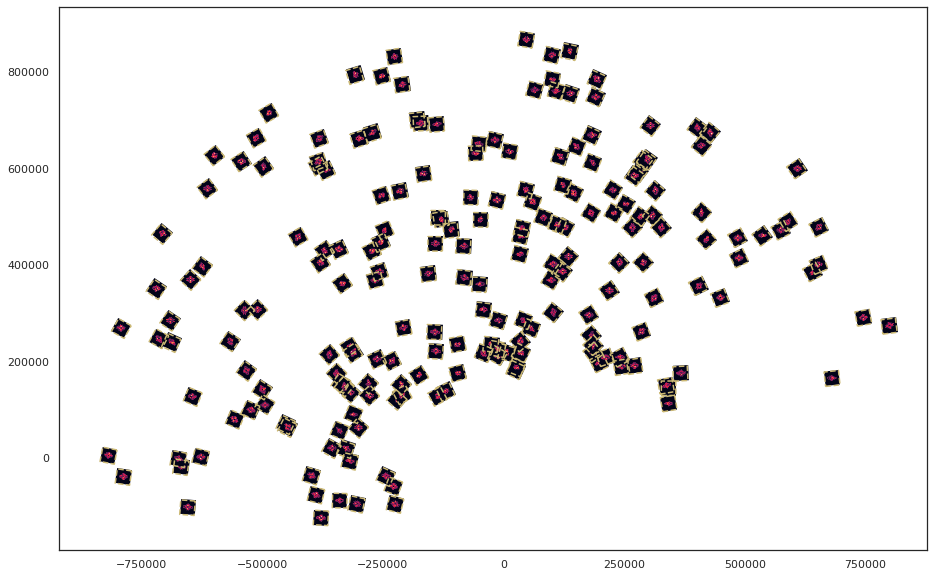

In [102]:
plot_images_equirectangular(angles_true, projections, indices=range(200), img_size_scale=30000)

(24, 24)


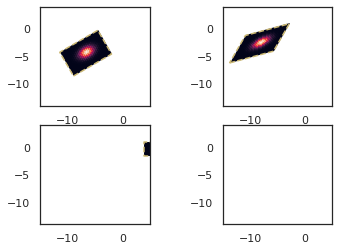

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms


def get_image():
    delta = 0.25
    x = y = np.arange(-3.0, 3.0, delta)
    X, Y = np.meshgrid(x, y)
    Z1 = np.exp(-X**2 - Y**2)
    #Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
    Z = (Z1 )
    print(Z.shape)
    return Z


def do_plot(ax, Z, transform):
    im = ax.imshow(Z, interpolation='none',
                   origin='lower',
                   extent=[-12, -4, -3, 2], clip_on=True)

    trans_data = transform + ax.transData
    im.set_transform(trans_data)

    # display intended extent of the image
    x1, x2, y1, y2 = im.get_extent()
    ax.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], "y--",
            transform=trans_data)
    ax.set_xlim(-15, 5)
    ax.set_ylim(-14, 4)


# prepare image and figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
Z = get_image()

# image rotation
do_plot(ax1, Z, mtransforms.Affine2D().rotate_deg(30))

# image skew
do_plot(ax2, Z, mtransforms.Affine2D().skew_deg(30, 15))

# scale and reflection
do_plot(ax3, Z, mtransforms.Affine2D().scale(-1, .5))

# everything and a translation
do_plot(ax4, Z, mtransforms.Affine2D().
        rotate_deg(30).skew_deg(30, 15).scale(-1, .5).translate(.5, -1))

plt.show()